In [181]:
import numpy as np
from FastCCM import CCM
from manifold_learning.utils import utils
from manifold_learning.data.data_loader import get_truncated_lorenz_rand
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from manifold_learning import imd_nd_smap
from sklearn.decomposition import PCA
import importlib
importlib.reload(imd_nd_smap)
importlib.reload(CCM)
import pandas as pd

In [2]:
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y,axis=1)**2 / (2 * sigma**2))

In [3]:
X = get_truncated_lorenz_rand(400,n_steps=20000,)

observables = StandardScaler().fit_transform(X)

In [4]:
exp_kernel_grid = np.array(np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),10), np.linspace(X[:,2].min(),X[:,2].max(),10))).reshape(2,-1).T

In [5]:
X_ = [get_truncated_lorenz_rand(400,n_steps=20000)[:,[0,2]] for i in range(5)]

In [6]:

observables = np.concatenate([np.array([gaussian_kernel(x,e,sigma=8) for e in exp_kernel_grid]) for x in X_]).T
#observables[observables < 0.1] = 0
mixing_mat = np.random.normal(size=(observables.shape[1],observables.shape[1]))
observables = observables @ mixing_mat
observables = StandardScaler().fit_transform(observables)


Text(0.5, 0, 'Time step')

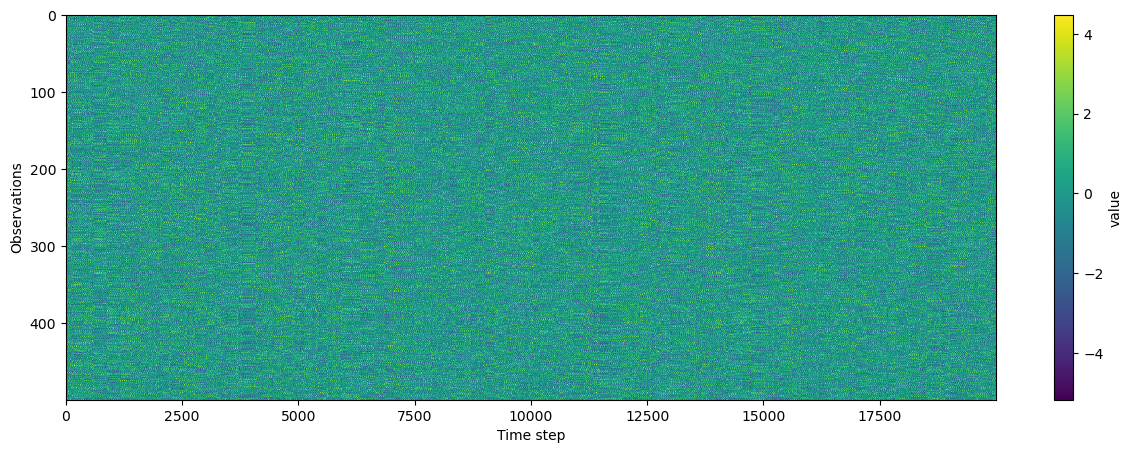

In [7]:
plt.figure(figsize=(15,5))
plt.imshow(observables.T,aspect="auto",interpolation="nearest")
plt.colorbar(label="value")
plt.ylabel("Observations")
plt.xlabel("Time step")

In [185]:
optimizers = [
    "Adam",
    "SGD",
    "AdamW",
    "RMSprop",
    "Adagrad",
    "Adadelta",
    "NAdam",
    "ASGD"
]

learning_rates = {
    "Adam": 1e-3,
    "SGD": 1e-2,
    "AdamW": 1e-3,
    "RMSprop": 1e-3,
    "Adagrad": 1e-2,
    "Adadelta": 1.0,  # Typically no explicit learning rate
    "NAdam": 1e-3,
    "ASGD": 1e-2
}


In [186]:
final_losses = []
final_ccm = []

for opt in optimizers:
    for exp in range(10):
        print(opt, exp)

        trainer = imd_nd_smap.IMD_nD_smap(observables.shape[1], embed_dim=10, n_components=5, subtract_corr=True, device="cuda")

        trainer.fit(observables, sample_len=150, library_len=800, 
            exclusion_rad=30, theta=8, tp=30, 
            epochs=500, num_batches=32,optimizer=opt, learning_rate=learning_rates[opt], tp_policy="range",loss_mask_size=3)
        
        final_losses += [trainer.get_loss_history().copy()]
        
        unmixed = trainer.predict(observables)

        ccm_matrix_unmixed = CCM.PairwiseCCM().compute(
            np.transpose(unmixed, axes=(1, 0, 2)),
            X_,
            1500, 400, 60,0,
            method="simplex",
            nbrs_num=15,
        ).mean(axis=0)

        final_ccm += [ccm_matrix_unmixed]

Adam 0
Epoch 1/500, Loss: 1.1233
Epoch 2/500, Loss: 1.0744
Epoch 3/500, Loss: 1.0283
Epoch 4/500, Loss: 0.9985
Epoch 5/500, Loss: 0.9721
Epoch 6/500, Loss: 0.9458
Epoch 7/500, Loss: 0.9282
Epoch 8/500, Loss: 0.9127
Epoch 9/500, Loss: 0.8992
Epoch 10/500, Loss: 0.8677
Epoch 11/500, Loss: 0.8461
Epoch 12/500, Loss: 0.8276
Epoch 13/500, Loss: 0.8175
Epoch 14/500, Loss: 0.8168
Epoch 15/500, Loss: 0.7868
Epoch 16/500, Loss: 0.7848
Epoch 17/500, Loss: 0.7689
Epoch 18/500, Loss: 0.7645
Epoch 19/500, Loss: 0.7376
Epoch 20/500, Loss: 0.7398
Epoch 21/500, Loss: 0.7110
Epoch 22/500, Loss: 0.6957
Epoch 23/500, Loss: 0.7006
Epoch 24/500, Loss: 0.6530
Epoch 25/500, Loss: 0.6786
Epoch 26/500, Loss: 0.6715
Epoch 27/500, Loss: 0.6168
Epoch 28/500, Loss: 0.6502
Epoch 29/500, Loss: 0.6276
Epoch 30/500, Loss: 0.6508
Epoch 31/500, Loss: 0.6078
Epoch 32/500, Loss: 0.6485
Epoch 33/500, Loss: 0.5985
Epoch 34/500, Loss: 0.6105
Epoch 35/500, Loss: 0.5998
Epoch 36/500, Loss: 0.5989
Epoch 37/500, Loss: 0.5907
Epo

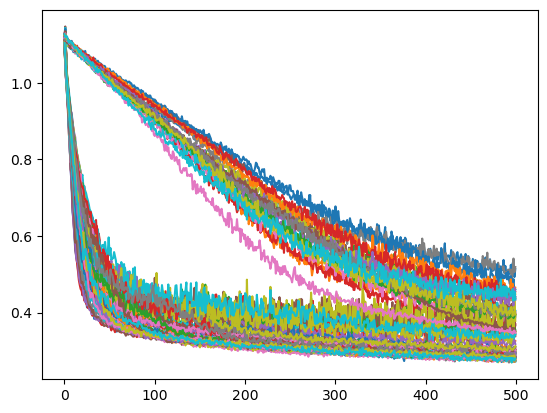

In [187]:
plt.plot(np.array(final_losses).T)

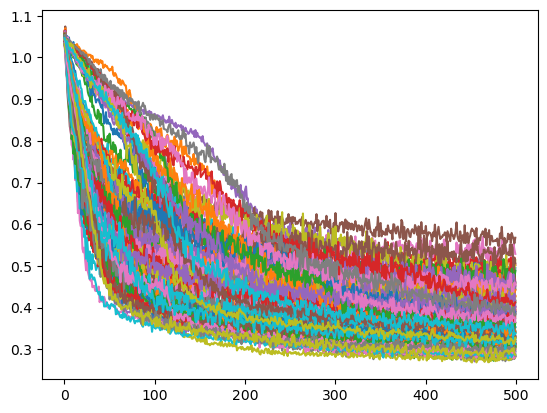

In [79]:
plt.plot(np.array(final_losses).T)

In [65]:
np.array(final_losses)

(80, 500)

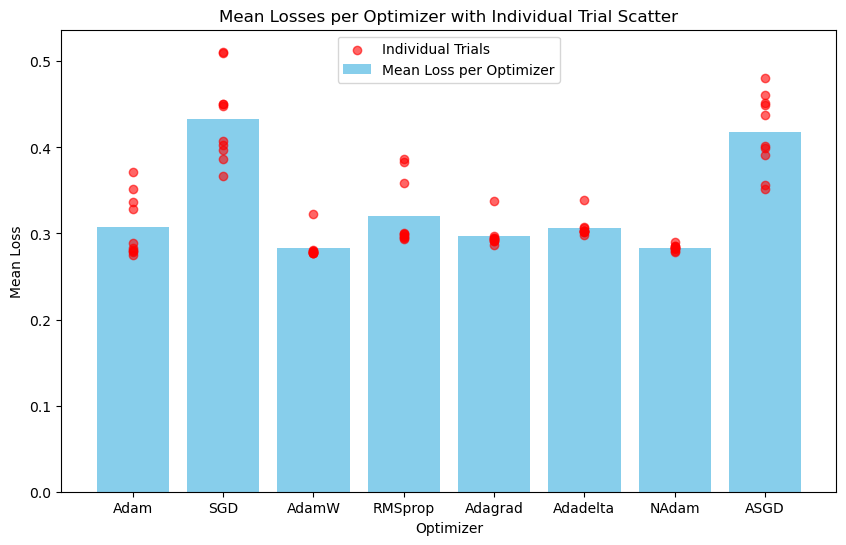

In [188]:

mean_losses = np.array(final_losses).reshape(8,10,-1)[:,:,-10:].mean(axis=2)

# Bar plot for means and scatter for individual trials
num_groups = mean_losses.shape[0]
num_trials = mean_losses.shape[1]

# Calculate bar heights (means) and scatter points for each group
means = mean_losses.mean(axis=1)
trial_points = [mean_losses[i, :] for i in range(num_groups)]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(num_groups)

# Bar plot for group means
ax.bar(x, means, color='skyblue', label='Mean Loss per Optimizer')

# Scatter plot for individual trials around each bar
for i in range(num_groups):
    ax.scatter([i] * num_trials, trial_points[i], color='red', alpha=0.6, label='Individual Trials' if i == 0 else "")

# Labeling and formatting
ax.set_xticks(x)
ax.set_xticklabels(optimizers[:8]) 
ax.set_xlabel("Optimizer")
ax.set_ylabel("Mean Loss")
ax.set_title("Mean Losses per Optimizer with Individual Trial Scatter")
ax.legend()

plt.show()

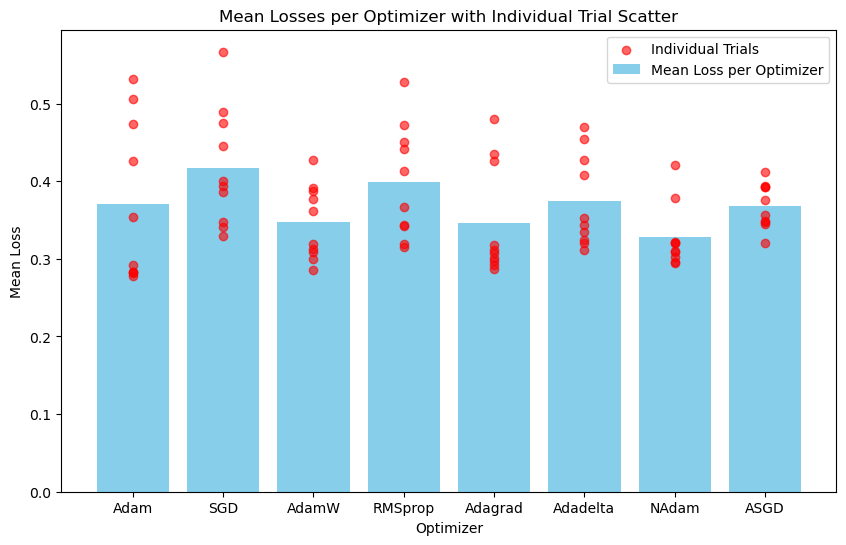

In [156]:

mean_losses = np.array(final_losses).reshape(8,10,-1)[:,:,-10:].mean(axis=2)

# Bar plot for means and scatter for individual trials
num_groups = mean_losses.shape[0]
num_trials = mean_losses.shape[1]

# Calculate bar heights (means) and scatter points for each group
means = mean_losses.mean(axis=1)
trial_points = [mean_losses[i, :] for i in range(num_groups)]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(num_groups)

# Bar plot for group means
ax.bar(x, means, color='skyblue', label='Mean Loss per Optimizer')

# Scatter plot for individual trials around each bar
for i in range(num_groups):
    ax.scatter([i] * num_trials, trial_points[i], color='red', alpha=0.6, label='Individual Trials' if i == 0 else "")

# Labeling and formatting
ax.set_xticks(x)
ax.set_xticklabels(optimizers[:8]) 
ax.set_xlabel("Optimizer")
ax.set_ylabel("Mean Loss")
ax.set_title("Mean Losses per Optimizer with Individual Trial Scatter")
ax.legend()

plt.show()

In [120]:

def get_udr(mat):
    mat = np.abs(mat)
    return (((mat.max(axis=0)**2)/mat.sum(axis=0)).sum() + ((mat.max(axis=1)**2)/mat.sum(axis=1)).sum())/np.sum(mat.shape)

(-0.5, 4.5, 4.5, -0.5)

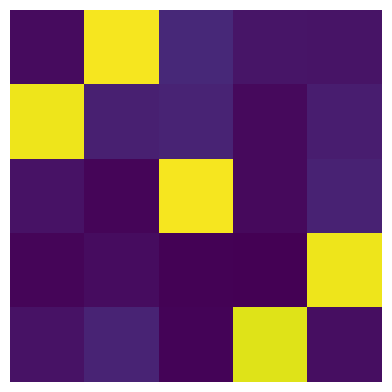

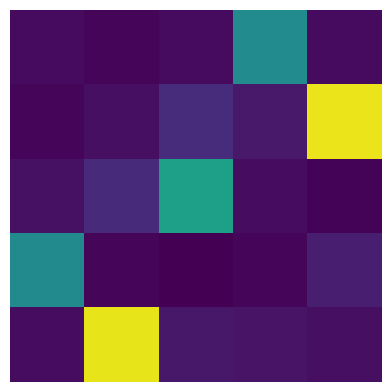

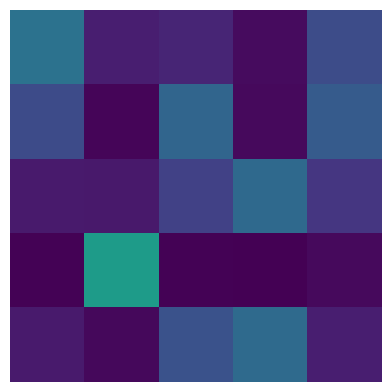

In [153]:
plt.matshow(np.abs(final_ccm[17]),vmax=1,vmin=0)
plt.axis("Off")
plt.matshow(np.abs(final_ccm[19]),vmax=1,vmin=0)
plt.axis("Off")
plt.matshow(np.abs(final_ccm[15]),vmax=1,vmin=0)
plt.axis("Off")

In [155]:
udr.flatten()[17], udr.flatten()[19], udr.flatten()[15]

(0.8143537521362305, 0.5531586170196533, 0.20862941741943358)

In [191]:

df = pd.DataFrame({
    "Optimizer": optimizers,
    "UDR Mean": udr.mean(axis=1),
    "UDR Std": udr.std(axis=1),
    "Mean Loss Mean": mean_losses.mean(axis=1),
    "Mean Loss Std": mean_losses.std(axis=1)
})

df.to_csv("results/optimizer_test_10d_5comp_linear.csv", index=False)

In [184]:
final_ccm_ = final_ccm.copy()
final_losses_ = final_losses.copy()

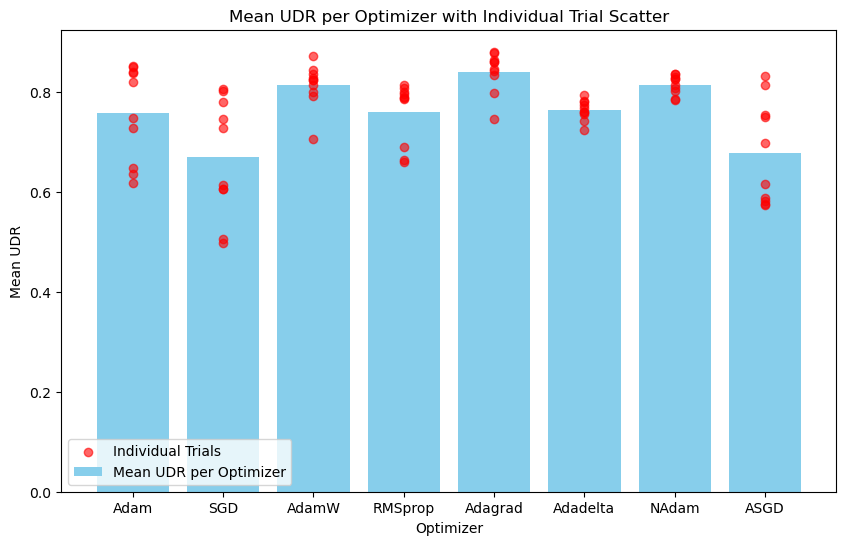

In [189]:

udr = np.array(([get_udr(np.abs(i)) for i in final_ccm])).reshape(8,10)


# Bar plot for means and scatter for individual trials
num_groups = udr.shape[0]
num_trials = udr.shape[1]

# Calculate bar heights (means) and scatter points for each group
means = udr.mean(axis=1)
trial_points = [udr[i, :] for i in range(num_groups)]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(num_groups)

# Bar plot for group means
ax.bar(x, means, color='skyblue', label='Mean UDR per Optimizer')

# Scatter plot for individual trials around each bar
for i in range(num_groups):
    ax.scatter([i] * num_trials, trial_points[i], color='red', alpha=0.6, label='Individual Trials' if i == 0 else "")

# Labeling and formatting
ax.set_xticks(x)
ax.set_xticklabels(optimizers[:8]) 
ax.set_xlabel("Optimizer")
ax.set_ylabel("Mean UDR")
ax.set_title("Mean UDR per Optimizer with Individual Trial Scatter")
ax.legend()

plt.show()

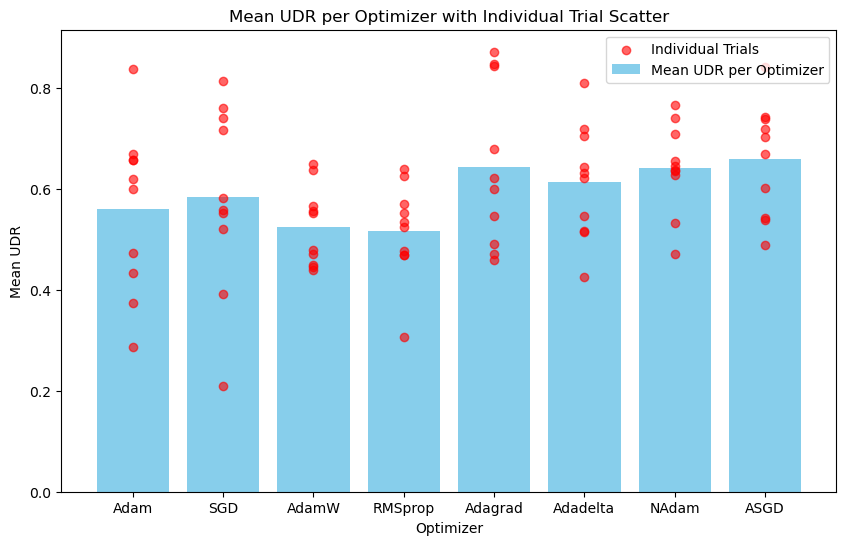

In [162]:

udr = np.array(([get_udr(np.abs(i)) for i in final_ccm])).reshape(8,10)


# Bar plot for means and scatter for individual trials
num_groups = udr.shape[0]
num_trials = udr.shape[1]

# Calculate bar heights (means) and scatter points for each group
means = udr.mean(axis=1)
trial_points = [udr[i, :] for i in range(num_groups)]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(num_groups)

# Bar plot for group means
ax.bar(x, means, color='skyblue', label='Mean UDR per Optimizer')

# Scatter plot for individual trials around each bar
for i in range(num_groups):
    ax.scatter([i] * num_trials, trial_points[i], color='red', alpha=0.6, label='Individual Trials' if i == 0 else "")

# Labeling and formatting
ax.set_xticks(x)
ax.set_xticklabels(optimizers[:8]) 
ax.set_xlabel("Optimizer")
ax.set_ylabel("Mean UDR")
ax.set_title("Mean UDR per Optimizer with Individual Trial Scatter")
ax.legend()

plt.show()

Text(0, 0.5, 'Loss func. value')

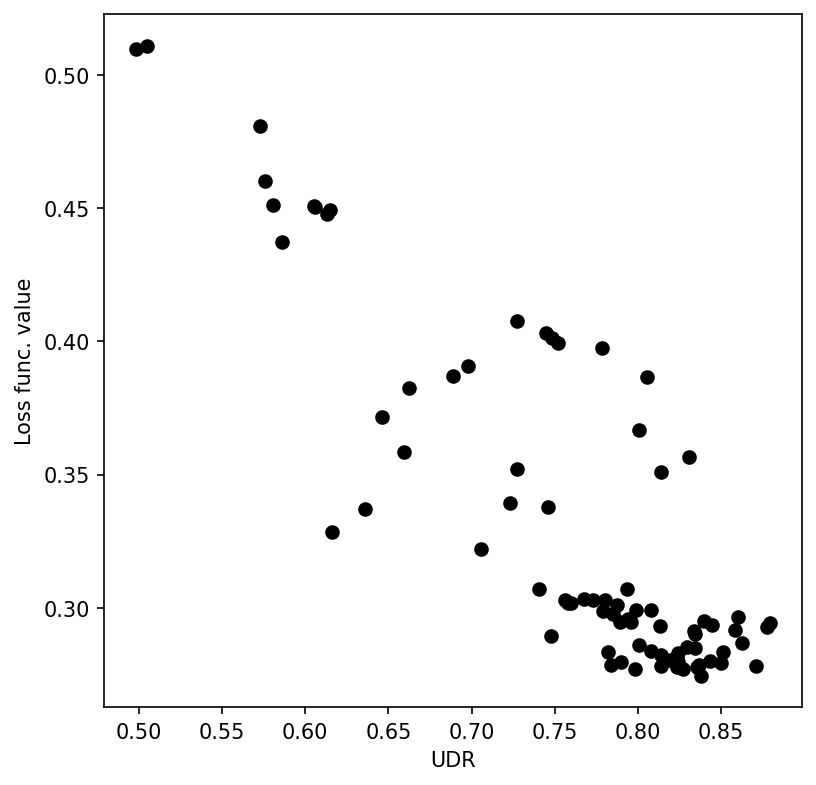

In [190]:
plt.figure(figsize=(6,6),dpi=150)
plt.scatter(udr.flatten(),mean_losses.flatten(),c="black")
plt.xlabel("UDR")
plt.ylabel("Loss func. value")

Text(0, 0.5, 'Loss func. value')

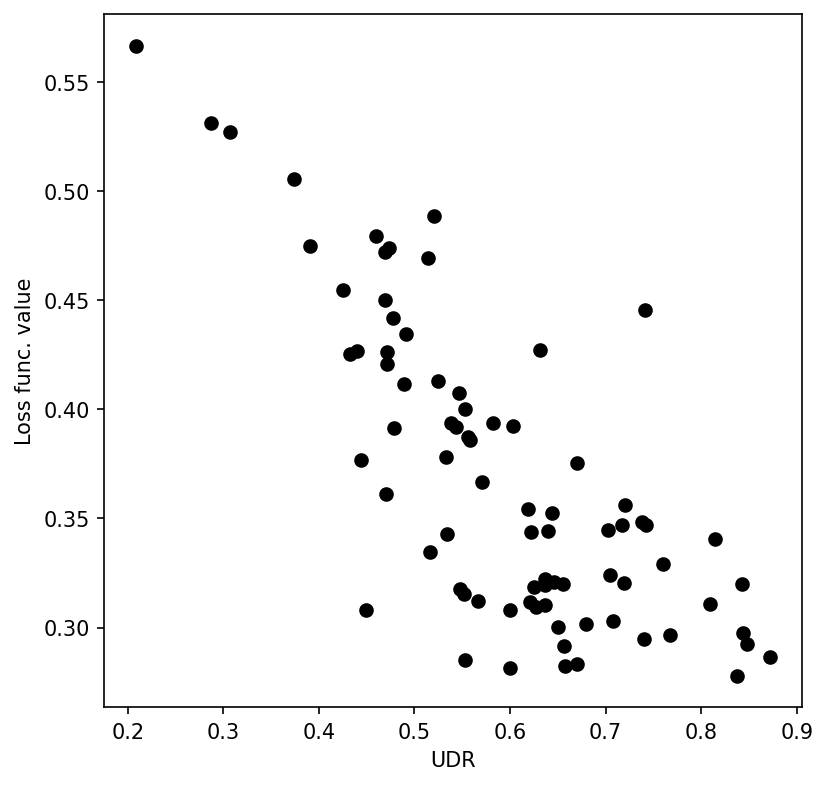

In [161]:
plt.figure(figsize=(6,6),dpi=150)
plt.scatter(udr.flatten(),mean_losses.flatten(),c="black")
plt.xlabel("UDR")
plt.ylabel("Loss func. value")